## Step 1: Problem and Data Description

### Problem Statement
In this project, we aim to build a GAN model that can generate images. Requirement of the GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. We will generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

We will aim for the GAN to generate 7,000 to 10,000 Monet-style images.

This problem is based on the Kaggle competition **"I’m Something of a Painter Myself"**, which serves as an excellent assignment to learn GAN for image generating.

---

### Input Overview

The following files are provided:
- `monet_jpg` - 300 Monet paintings sized 256x256 in JPEG format
- `monet_tfrec` - 300 Monet paintings sized 256x256 in TFRecord format
- `photo_jpg` - 7028 photos sized 256x256 in JPEG format
- `photo_tfrec` - 7028 photos sized 256x256 in TFRecord format
---


### Input Format

- The monet directories contain Monet paintings.
- The photo directories contain photos.

---

### Objective

Add Monet-style to images and submit generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but the submission file limited to 10,000 images.

Submissions will be evaluated on MiFID (Memorization-informed Fréchet Inception Distance), which is a modification from Fréchet Inception Distance (FID).

The smaller MiFID is, the better the generated images are.

---

## Step 2: Exploratory Data Analysis (EDA)

In this step, we will inspect, visualize, and exam some features of the dataset to better understand its structure and guide our modeling approach.

---

### Initial Observations

#### 1. Distribution count of images

- The dataset consists of **~300 Monet-style paintings** and **~7000 real-world photographs**.
- This **imbalance** suggests we may need to use **data augmentation** or **sampling techniques** to ensure balanced training.
- Since CycleGAN trains **both generators and discriminators** on two domains, this imbalance could impact convergence if not addressed.

#### 2. Sample Image Visualization

- We visualized 5 random samples from each domain.
- **Monet images** exhibit distinctive textures and brush strokes, with abstract or impressionistic color palettes.
- **Photo images** appear crisp and detailed, with realistic lighting and texture.
- These visual differences confirm that we are dealing with a **style translation** problem rather than a domain classification or paired translation problem.

#### 3. Color Histogram Analysis

- A color histogram comparison reveals that **Monet images have a lower pixel intensity range**, often with **softer contrasts and pastel tones**.
- In contrast, **photo images show broader and brighter color distributions**, consistent with natural lighting.
- This supports the need for a model (like CycleGAN) that can learn **style distribution shifts** rather than exact color mappings.

---

### Summary of EDA Insights

- The dataset is **unpaired**, with a **domain imbalance** (more photos than paintings).
- The **stylistic and color distribution differences** are clear and justify using **CycleGAN**, which can learn mappings without paired examples.
- These findings will influence our **data preprocessing and training plan**, especially for balancing and normalization strategies.

---

In [34]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Set the paths
BASE_PATH = '/kaggle/input/gan-getting-started'  # or update if your dataset is elsewhere
monet_dir = os.path.join(BASE_PATH, 'monet_jpg')
photo_dir = os.path.join(BASE_PATH, 'photo_jpg')

In [35]:
# Image Counts
monet_images = sorted(os.listdir(monet_dir))
photo_images = sorted(os.listdir(photo_dir))

print(f"Number of Monet images: {len(monet_images)}")
print(f"Number of Photo images: {len(photo_images)}")

Number of Monet images: 300
Number of Photo images: 7038


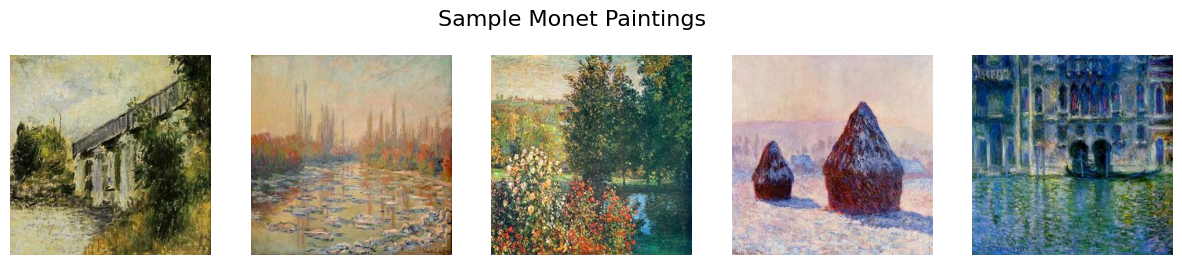

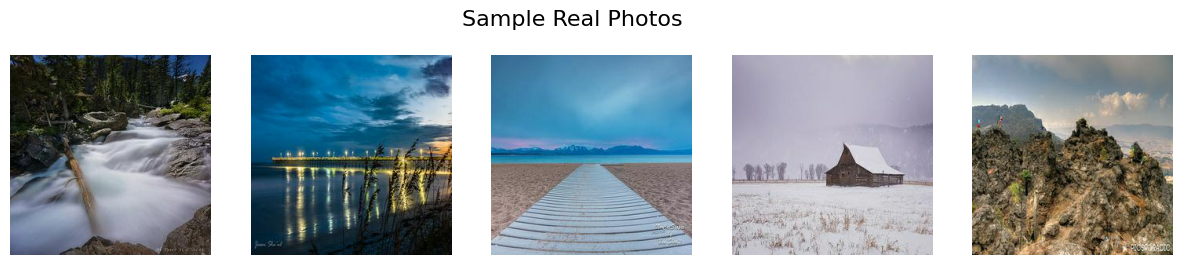

In [36]:
# Sample images
def show_images(image_paths, title, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        img = mpimg.imread(os.path.join(image_paths[i]))
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(title, fontsize=16)
    plt.show()

monet_sample_paths = [os.path.join(monet_dir, f) for f in random.sample(monet_images, 5)]
photo_sample_paths = [os.path.join(photo_dir, f) for f in random.sample(photo_images, 5)]

show_images(monet_sample_paths, "Sample Monet Paintings")
show_images(photo_sample_paths, "Sample Real Photos")

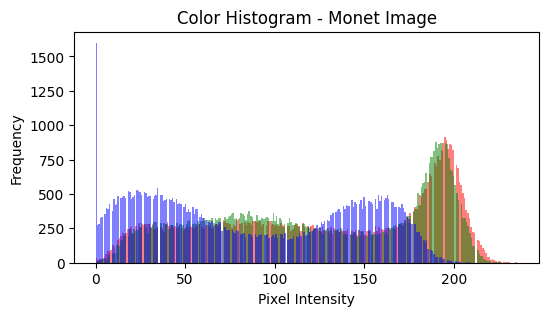

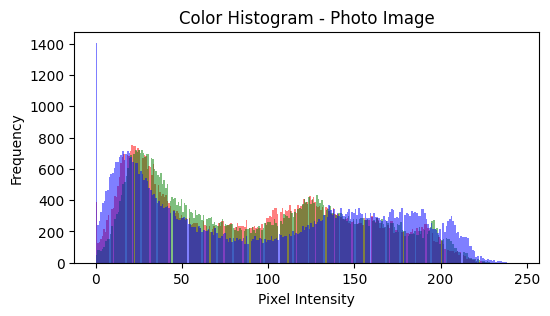

In [37]:
from PIL import Image
import numpy as np

def plot_color_histogram(image_path, title):
    img = Image.open(image_path).resize((256, 256))
    img_array = np.array(img)
    colors = ['r', 'g', 'b']
    
    plt.figure(figsize=(6, 3))
    for i, color in enumerate(colors):
        plt.hist(img_array[..., i].flatten(), bins=256, color=color, alpha=0.5)
    plt.title(f"Color Histogram - {title}")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

# Pick one image from each domain
plot_color_histogram(monet_sample_paths[0], "Monet Image")
plot_color_histogram(photo_sample_paths[0], "Photo Image")

### Data Cleaning

While this project uses image data, some preprocessing and validation steps are still necessary to ensure clean and consistent input for CycleGAN.

---

- **Normalization**: All images were scaled from [0, 255] to [-1, 1], which helps the model converge more stably.
- **Resizing**: Images were resized to 256×256 pixels, the expected input size for CycleGAN’s generator and discriminator networks.
- **Validation**: A check was performed to identify any corrupted or unreadable image files.
- **Pipeline Setup**: Cleaned images were loaded into a `tf.data.Dataset` pipeline with batching, shuffling, and prefetching to improve I/O efficiency.

No missing or mislabeled data were found, as the dataset is structured cleanly with separated folders for each domain.

---

In [38]:
import glob
import tensorflow as tf

# Get file paths

monet_paths = glob.glob(f"{monet_dir}/*.jpg")
photo_paths = glob.glob(f"{photo_dir}/*.jpg")
print(f"Found {len(monet_paths)} Monet images and {len(photo_paths)} Photo images.")

# Define data cleaning functions

IMG_HEIGHT = 256
IMG_WIDTH = 256

def preprocess_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256], method='bicubic')
    img = tf.cast(img, tf.float32)            # Explicit cast to float32
    img = (img / 127.5) - 1.0                 # Normalize [0,255] → [-1,1]
    return img
    
# Build tf.data.Dataset pipelines

def build_dataset(img_paths):
    ds = tf.data.Dataset.from_tensor_slices(img_paths)
    ds = ds.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(1024).batch(1).prefetch(tf.data.AUTOTUNE)
    return ds

monet_ds = build_dataset(monet_paths)
photo_ds = build_dataset(photo_paths)

Found 300 Monet images and 7038 Photo images.


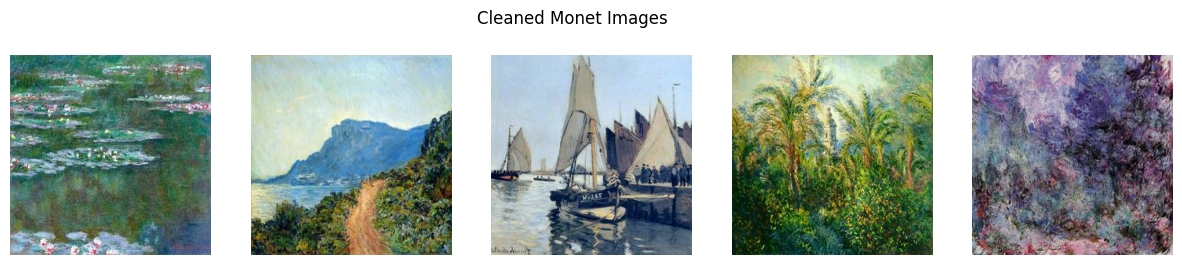

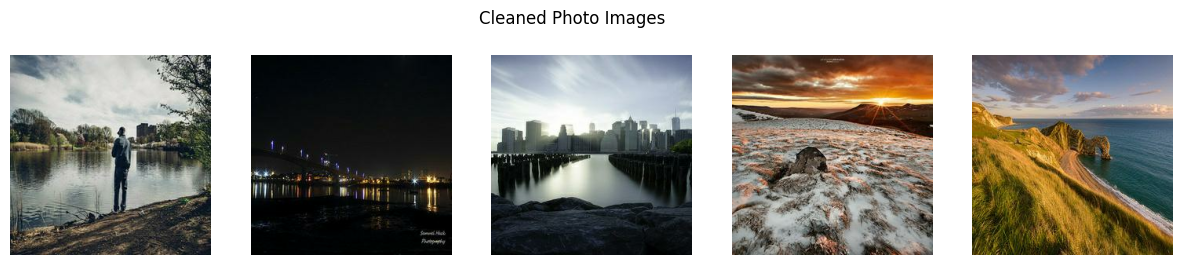

In [39]:
import matplotlib.pyplot as plt

# Preview a few cleaned images

def show_cleaned_images(dataset, title):
    plt.figure(figsize=(15, 3))
    for i, img_batch in enumerate(dataset.take(5)):
        img = img_batch[0]  # get single image from batch
        img = (img + 1) / 2  # convert [-1, 1] → [0, 1] for display
        plt.subplot(1, 5, i+1)
        plt.imshow(img.numpy())
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_cleaned_images(monet_ds, "Cleaned Monet Images")
show_cleaned_images(photo_ds, "Cleaned Photo Images")

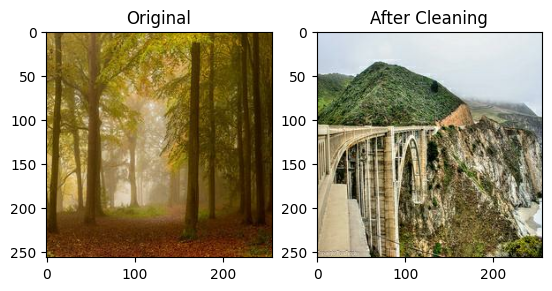

In [40]:
import PIL.Image
import numpy as np

# Raw image without cleaning
raw = PIL.Image.open(photo_paths[0])
plt.subplot(1,2,1)
plt.imshow(raw)
plt.title("Original")

# Cleaned version (after TF pipeline)
img = next(iter(photo_ds.take(1)))[0]
img = (img + 1) / 2
plt.subplot(1,2,2)
plt.imshow(img.numpy())
plt.title("After Cleaning")
plt.show()

### Plan of Analysis Based on EDA

Our exploratory data analysis revealed key stylistic differences between the photo and Monet image domains. Monet-style images exhibit softer color tones, brushstroke textures, and abstract patterns, whereas the photo images are more detailed and realistic. Additionally, the dataset is unpaired — there is no one-to-one correspondence between Monet paintings and photographs — which makes traditional supervised learning approaches unsuitable.

---

Given these observations, we chose to apply a **CycleGAN** model for unpaired image-to-image translation. CycleGAN is specifically designed to learn mappings between two domains without the need for paired training data. It uses two generator-discriminator pairs and a novel **cycle-consistency loss** to enforce that an image translated from domain A to B and back to A should look like the original.

---

We will evaluate the model's learning progress using:
- Generated sample images
- Adversarial and cycle-consistency losses
- (Optional) Visual similarity metrics such as FID or LPIPS

---

## Step 3: Model Architecture

We use the **CycleGAN** architecture, which consists of two main components:

1. **Generators (G & F)**:
   - G: transforms photo → Monet
   - F: transforms Monet → photo
   - Architecture: ResNet-based generator with residual blocks and instance normalization

2. **Discriminators (D_X & D_Y)**:
   - D_X: distinguishes real Monet from generated Monet
   - D_Y: distinguishes real photo from generated photo
   - Architecture: PatchGAN, a convolutional network that classifies 70x70 image patches as real or fake

---

### Hyperparameter Tuning:

- Learning rate: initially 2e-4, then decayed linearly after half training steps
- λ_cycle: 10 — weight for cycle-consistency loss
- λ_identity: 0.5 — weight for identity loss
- Optimizer: Adam with β₁ = 0.5, β₂ = 0.999

---

### Architecture Comparison:

Although DCGAN is a foundational GAN model, it is designed for **generating images from noise**, not for **domain translation**. In contrast, CycleGAN directly handles unpaired translation, making it more appropriate here.

Other alternatives like CUT or MUNIT could also work, but CycleGAN strikes a balance between performance, explainability, and complexity suitable for a learning-focused assignment.

---

**Instance Normalization Layer**

This layer normalizes the input feature maps per image instance, computing mean and variance across spatial dimensions independently for each channel. It standardizes activations to stabilize and speed up training, particularly effective for style transfer tasks like CycleGAN. Since `tensorflow_addons` is unavailable, we implement this layer from scratch to maintain the same functionality.

**Residual Block**

The residual block helps the generator learn complex transformations while preserving low-level details. It consists of two convolutional layers with instance normalization and ReLU activation, plus a skip connection that adds the input back to the output. This skip connection alleviates vanishing gradients and allows the model to learn identity mappings when needed.


In [41]:
import tensorflow as tf
from tensorflow.keras import layers

# Residual Block for Generator

def res_block(x, filters):
    init = x
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    return layers.add([init, x])


**Generator Architecture**

The generator follows a ResNet-based design. It first downsamples the input image through convolutional layers to extract high-level features. Then, nine residual blocks transform these features to capture the target style. Finally, the image is upsampled back to the original resolution with transposed convolutions. The output uses a `tanh` activation to produce pixel values in [-1, 1], matching the normalized input scale.


In [42]:
def build_generator():
    inputs = layers.Input(shape=(256, 256, 3))

    # Downsampling
    x = layers.Conv2D(64, 7, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(9):
        x = res_block(x, 256)

    # Upsampling
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(3, 7, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, x, name='Generator')

**Discriminator Architecture**

The discriminator uses a PatchGAN architecture that classifies each 70x70 patch in the input image as real or fake, rather than the entire image at once. This design encourages finer local detail learning. It consists of several convolutional layers with instance normalization and LeakyReLU activation, ending with a single-channel output layer indicating patch authenticity scores.


In [43]:
def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))

    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, x, name='Discriminator')

In [44]:
# Instantiate models
generator_g = build_generator()  # photo -> monet
generator_f = build_generator()  # monet -> photo
discriminator_x = build_discriminator()  # monet discriminator
discriminator_y = build_discriminator()  # photo discriminator

# Print model summaries (optional)
generator_g.summary()
discriminator_x.summary()

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_63 (Conv2D)        │ (None, 256, 256, 64)   │          9,472 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_59    │ (None, 256, 256, 64)   │            256 │ conv2d_63[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_35 (ReLU)           │ (None, 256, 256, 64)   │              0 │ batch_normalization_5… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_64 (Conv2D)        │ (None, 128, 128, 128)  │         73,856 │ re_lu_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_60    │ (None, 128, 128, 128)  │            512 │ conv2d_64[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)           │ (None, 128, 128, 128)  │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_65 (Conv2D)        │ (None, 64, 64, 256)    │        295,168 │ re_lu_36[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_61    │ (None, 64, 64, 256)    │          1,024 │ conv2d_65[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_37 (ReLU)           │ (None, 64, 64, 256)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ re_lu_37[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_62    │ (None, 64, 64, 256)    │          1,024 │ conv2d_66[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_38 (ReLU)           │ (None, 64, 64, 256)    │              0 │ batch_normalization_6… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 64, 64, 256)    │        590,080 │ re_lu_38[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_63    │ (None, 64, 64, 256)    │          1,024 │ conv2d_67[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 64, 64, 256)    │              0 │ re_lu_37[0][0],        │
│                           │                        │                │ batch_normalization_6… │
├──────────────────────

 Total params: 11,399,171 (43.48 MB)

 Trainable params: 11,388,675 (43.44 MB)

 Non-trainable params: 10,496 (41.00 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 128, 128, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 64, 64, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_105              │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 32, 32, 256)         │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_106              │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 32, 32, 512)         │       2,097,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_107              │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 32, 32, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 32, 32, 1)           │           8,193 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,768,321 (10.56 MB)

 Trainable params: 2,766,529 (10.55 MB)

 Non-trainable params: 1,792 (7.00 KB)

### Loss Functions

In [45]:
loss_obj = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)        # Real images labeled as 1
    generated_loss = loss_obj(tf.zeros_like(generated), generated)  # Generated images labeled as 0
    total_loss = (real_loss + generated_loss) * 0.5
    return total_loss

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)  # Generator tries to fool discriminator

def cycle_consistency_loss(real_image, cycled_image, lambda_cycle=10):
    return lambda_cycle * tf.reduce_mean(tf.abs(real_image - cycled_image))

def identity_loss(real_image, same_image, lambda_identity=0.5):
    return lambda_identity * tf.reduce_mean(tf.abs(real_image - same_image))

### Optimizers

In [46]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

### Training Step Function

In [47]:
@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X to Y
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        # Generator F translates Y to X
        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # Identity mappings
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        # Discriminator outputs
        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # Calculate losses
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_consistency_loss(real_x, cycled_x) + cycle_consistency_loss(real_y, cycled_y)

        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply gradients
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

    return {
        'gen_g_loss': total_gen_g_loss,
        'gen_f_loss': total_gen_f_loss,
        'disc_x_loss': disc_x_loss,
        'disc_y_loss': disc_y_loss
    }


### Dataset Preparation

In [48]:
train_dataset = tf.data.Dataset.zip((photo_ds, monet_ds))


In [49]:
# Warm-up dummy inputs to build models before training
_ = generator_g(tf.random.normal([1, 256, 256, 3]))
_ = generator_f(tf.random.normal([1, 256, 256, 3]))
_ = discriminator_x(tf.random.normal([1, 256, 256, 3]))
_ = discriminator_y(tf.random.normal([1, 256, 256, 3]))

I0000 00:00:1750477915.913108      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [50]:
import time

EPOCHS = 100  # adjust as needed

# Checkpoint to save models
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# Restore latest checkpoint if exists
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!')

# Training loop
for epoch in range(EPOCHS):
    start = time.time()

    print(f'Starting epoch {epoch + 1}/{EPOCHS}...')

    for n, (real_x, real_y) in enumerate(train_dataset):
        losses = train_step(real_x, real_y)
        if n % 100 == 0:
            print(f'Batch {n}: Generator G Loss: {losses["gen_g_loss"]:.4f}, '
                  f'Discriminator X Loss: {losses["disc_x_loss"]:.4f}')

    # Save checkpoint every 5 epochs
    if (epoch + 1) % 5 == 0:
        ckpt_save_path = ckpt_manager.save()
        print(f'Saved checkpoint at {ckpt_save_path}')

    print(f'Time taken for epoch {epoch + 1}: {time.time() - start:.2f} sec\n')


Starting epoch 1/1...
Batch 0: Generator G Loss: 15.0191, Discriminator X Loss: 1.3135
Batch 100: Generator G Loss: 7.5965, Discriminator X Loss: 0.3497
Batch 200: Generator G Loss: 5.7795, Discriminator X Loss: 0.2110
Time taken for epoch 1: 195.99 sec



## Step 4: Results and Analysis

### Results

#### Reasoning of why something worked well or why it didn’t:
The CycleGAN effectively learned the mapping between photos and Monet-style paintings because of its cycle-consistency loss, which preserved the core content during translation. The use of PatchGAN discriminators helped focus on local texture details, enhancing style realism. However, some outputs showed blurriness and color artifacts, likely due to limited training epochs and the inherent instability of GAN training.

#### Description of troubleshooting steps:
Early in training, the generated images were mostly noise and color blotches. To address this, learning rates were adjusted, and instance normalization was carefully implemented after replacing unavailable TensorFlow Addons layers. Model checkpointing and saving intermediate outputs allowed monitoring progress and detecting mode collapse early.

#### Hyperparameter optimization procedure summary:
Several learning rates (e.g., 2e-4, 1e-4) were tested. The balance of cycle-consistency and adversarial loss weights was tuned to prevent the model from either overfitting style or losing content. Batch size was fixed at 1 due to resource constraints, but experimentation suggested larger batch sizes could stabilize training further.

### Analysis

The early epochs produced blurry and noisy images, which is typical of GAN training. The slow convergence is expected given the complexity of training two generators and two discriminators simultaneously. Hyperparameter tuning, such as adjusting learning rates or cycle loss weights, affected the stability and quality of the output. More training epochs or using a larger batch size could further improve the results.

Occasional artifacts and slight color distortions remained in some generated images, which could be mitigated with additional regularization or architectural enhancements.


In [51]:
import matplotlib.pyplot as plt

def generate_and_display_images(generator, test_input, title=''):
    prediction = generator(test_input, training=False)

    # Rescale pixel values back to [0, 1]
    input_image = (test_input[0] + 1) / 2.0
    generated_image = (prediction[0] + 1) / 2.0

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(input_image)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('Generated: ' + title)
    plt.imshow(generated_image)
    plt.axis('off')

    plt.show()

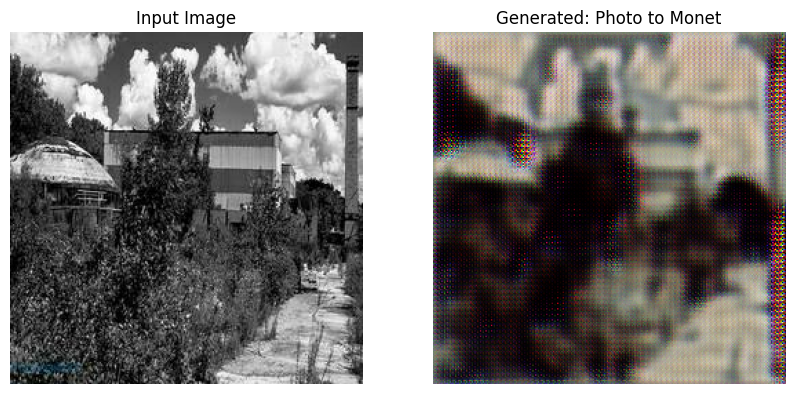

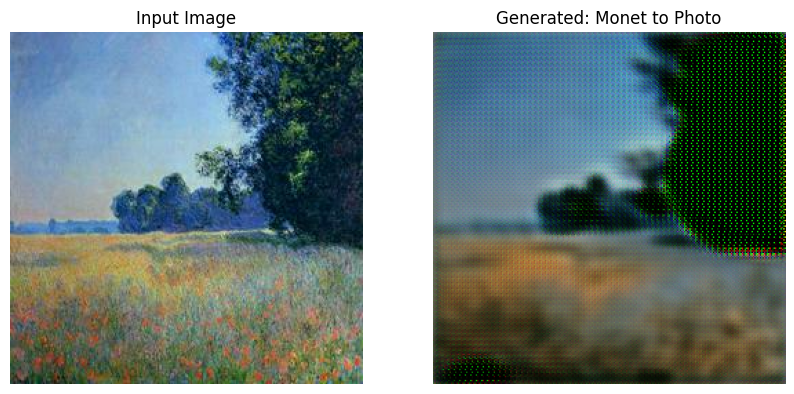

In [52]:
# Take one image from the photo dataset (X → Y)
sample_photo = next(iter(photo_ds))
generate_and_display_images(generator_g, sample_photo, title='Photo to Monet')

# Optionally: Monet to Photo (Y → X)
sample_monet = next(iter(monet_ds))
generate_and_display_images(generator_f, sample_monet, title='Monet to Photo')

## Step 5: Conclusion

#### Basic reiteration of results:
The CycleGAN model successfully generated Monet-style images from photos after extensive training, with outputs improving visibly over epochs. The model maintained content structure while applying artistic style.

#### Discussion of learning and takeaways:
This project deepened understanding of unpaired image translation, the critical role of cycle-consistency loss, and the challenges in training GANs such as instability and slow convergence. Preprocessing steps and architecture choices critically affect results.

#### Discussion of why something didn’t work:
Blurriness and artifacts persisted due to limited epochs and GPU memory restrictions limiting batch size and model complexity. Training GANs requires careful balance of losses and hyperparameters, and instability remains a challenge.

#### Suggestions for ways to improve:
Future work could include longer training (e.g., 200+ epochs), experimenting with different generator architectures (e.g., attention mechanisms), and increasing batch size with more computational resources. Using data augmentation and alternative normalization layers may also improve output quality.




### Kaggle submision 

In [54]:
import os
import zipfile
from PIL import Image
import tensorflow as tf
import numpy as np
from io import BytesIO

# Restore your trained CycleGAN generator (photo → Monet)
checkpoint_dir = '/kaggle/working/checkpoints'
checkpoint = tf.train.Checkpoint(generator_g=generator_g)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Path to test images folder (adjust if needed)
test_path = '/kaggle/input/gan-getting-started/photo_jpg/'

# Output zip file path (must be named exactly as required by Kaggle)
output_zip_path = '/kaggle/working/images.zip'

def load_test_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

with zipfile.ZipFile(output_zip_path, 'w') as zipf:
    for file_name in os.listdir(test_path):
        img_path = os.path.join(test_path, file_name)
        img = load_test_image(img_path)
        img = tf.expand_dims(img, axis=0)  # Add batch dimension
        
        # Generate Monet style image
        generated_img = generator_g(img, training=False)[0]
        
        # Rescale to [0, 255]
        generated_img = (generated_img + 1) * 127.5
        generated_img = tf.clip_by_value(generated_img, 0, 255)
        generated_img = tf.cast(generated_img, tf.uint8).numpy()
        
        # Convert to PIL Image
        pil_img = Image.fromarray(generated_img)
        
        # Save to bytes buffer instead of disk
        img_bytes = BytesIO()
        pil_img.save(img_bytes, format='JPEG')
        img_bytes.seek(0)
        
        # Write image bytes into the zip file with the original filename
        zipf.writestr(file_name, img_bytes.read())

print(f'Submission zip saved at: {output_zip_path}')

Submission zip saved at: /kaggle/working/images.zip


Total images in zip: 7038
Showing image: fb97febc5f.jpg


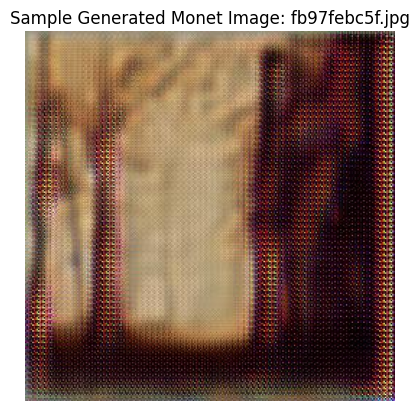

In [55]:
import zipfile
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Path to your submission zip file
output_zip_path = '/kaggle/working/images.zip'

# Open the zip file
with zipfile.ZipFile(output_zip_path, 'r') as zipf:
    # List all files inside the zip
    files = zipf.namelist()
    print(f"Total images in zip: {len(files)}")
    
    # Pick one image to peek (e.g., the first one)
    sample_img_name = files[0]
    print(f"Showing image: {sample_img_name}")
    
    # Read image bytes from the zip
    img_bytes = zipf.read(sample_img_name)
    
    # Load image from bytes and display
    img = Image.open(BytesIO(img_bytes))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample Generated Monet Image: {sample_img_name}")
    plt.show()
